In [2]:
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
train_X_root = './dataset/lab13/mnist/'
train_Y_root = './dataset/lab13/svhn/'

# Batch size during training
bs = 64

# Size of image size
img_height = 32
img_width = 32
img_size = 32
img_depth = 3

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
m_transform = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_X_set = dset.MNIST(root=train_X_root,
                         train=True,
                         transform=m_transform,
                         download=True)
train_Y_set = dset.SVHN(root=train_Y_root,
                        split='train',
                        transform=transform,
                        download=True)
test_X_set = dset.MNIST(root=train_X_root,
                         train=False,
                         transform=m_transform,
                         download=True)
test_Y_set = dset.SVHN(root=train_Y_root,
                        split='test',
                        transform=transform,
                        download=True)


STEP 1: LOADING DATASET
Using downloaded and verified file: ./dataset/lab13/svhn/train_32x32.mat
Using downloaded and verified file: ./dataset/lab13/svhn/test_32x32.mat


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_X_loader = torch.utils.data.DataLoader(train_X_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

train_Y_loader = torch.utils.data.DataLoader(train_Y_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

test_X_loader = torch.utils.data.DataLoader(test_X_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

test_Y_loader = torch.utils.data.DataLoader(test_Y_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

STEP 2: MAKING DATASET ITERABLE


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

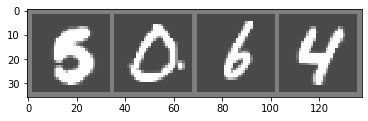

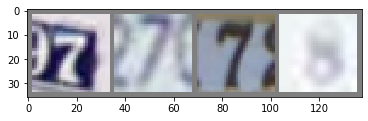

In [7]:
data_loader_X_sample = torch.utils.data.DataLoader(train_X_set,
                                                 batch_size=4, 
                                                 shuffle=True)
data_loader_Y_sample = torch.utils.data.DataLoader(train_Y_set,
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data

X = next(iter(data_loader_X_sample))
Y = next(iter(data_loader_Y_sample))


# Make a grid from batch
out_X = torchvision.utils.make_grid(X[0])
out_Y = torchvision.utils.make_grid(Y[0])

imshow(out_X)
imshow(out_Y)

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
    
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_g_enc_X = [[1, 64, 7, 2, 3,"LeakyReLU"], [64, 128, 3, 2, 1, "LeakyReLU"]]
cfg_g_enc_Y = [[3, 64, 7, 2, 3,"LeakyReLU"], [64, 128, 3, 2, 1, "LeakyReLU"]]
cfg_g_trans = [[128, 128, 3, 1, 1, "LeakyReLU" ], [128, 128, 3, 1, 1, "LeakyReLU"], [128, 128, 3, 1, 1, "LeakyReLU"]]
cfg_g_dec_X = [[128, 64, 4, 2, 1, "LeakyReLU"], [64, 3, 4, 2, 1, "Tanh"]]
cfg_g_dec_Y = [[128, 64, 4, 2, 1, "LeakyReLU"], [64, 1, 4, 2, 1, "Tanh"]]


class Generator_X(nn.Module):
    def __init__(self, enc, trans, dec):
        super(Generator_X, self).__init__()
        
        
        self.conv1 = conv2d(enc[0], False)
        self.conv2 = conv2d(enc[1])
        self.conv3 = conv2d(trans[0])
        self.conv4 = conv2d(trans[1])
        self.conv5 = conv2d(trans[2])
        self.upconv1 = upconv2d(dec[0])
        self.upconv2 = upconv2d(dec[1], False)
        
        
    def forward(self, x):
        
        #############
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) + x
        x = self.conv4(x) + x
        x = self.conv5(x) + x
        x = self.upconv1(x)
        x = self.upconv2(x)
        
        return x
        #############
    
class Generator_Y(nn.Module):
    def __init__(self, enc, trans, dec):
        super(Generator_Y, self).__init__()
        
        #############
        self.conv1 = conv2d(enc[0], False)
        self.conv2 = conv2d(enc[1])
        self.conv3 = conv2d(trans[0])
        self.conv4 = conv2d(trans[1])
        self.conv5 = conv2d(trans[2])
        self.upconv1 = upconv2d(dec[0])
        self.upconv2 = upconv2d(dec[1], False)
        #############
        
        
    def forward(self, x):
        
        #############
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) + x
        x = self.conv4(x) + x
        x = self.conv5(x) + x
        x = self.upconv1(x)
        x = self.upconv2(x)
        
        return x
        #############  
        

STEP 3-1: CREATE MODEL CLASS (Generator)


In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_d_X = [[1, 64, 4, 2, 1,"LeakyReLU"], [64, 128, 4, 2, 1,"LeakyReLU"], [128, 256, 4, 1, 1,"LeakyReLU"], [256, 1, 2, 1, 1,"Sigmoid"]]
cfg_d_Y = [[3, 64, 4, 2, 1,"LeakyReLU"], [64, 128, 4, 2, 1,"LeakyReLU"], [128, 256, 4, 1, 1,"LeakyReLU"], [256, 3, 2, 1, 1,"Sigmoid"]]


class Discriminator_X(nn.Module):
    def __init__(self, cfg):
        super(Discriminator_X, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg[0], False)
        self.conv2 = conv2d(cfg[1])
        self.conv3 = conv2d(cfg[2])
        self.conv4 = conv2d(cfg[3], False)
        #############
        
    def forward(self, x):
        
        #############
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        return x
        #############
    
class Discriminator_Y(nn.Module):
    def __init__(self, cfg):
        super(Discriminator_Y, self).__init__()
        
        #############
        self.conv1 = conv2d(cfg[0], False)
        self.conv2 = conv2d(cfg[1])
        self.conv3 = conv2d(cfg[2])
        self.conv4 = conv2d(cfg[3], False)
        #############
        
    def forward(self, x):
        
        #############
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        return x
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G_X = Generator_X(cfg_g_enc_X, cfg_g_trans, cfg_g_dec_X)
model_G_Y = Generator_Y(cfg_g_enc_Y, cfg_g_trans, cfg_g_dec_Y)
model_D_X = Discriminator_X(cfg_d_X)
model_D_Y = Discriminator_Y(cfg_d_Y)


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G_X.to(device)
print(model_G_X)
model_G_Y.to(device)
print(model_G_Y)
model_D_X.to(device)
print(model_D_X)
model_D_Y.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator_X(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv5): Sequential(
    (0): C

Discriminator_Y(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G_X = torch.optim.Adam(model_G_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_Y = torch.optim.Adam(model_G_Y.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = torch.optim.Adam(model_D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = torch.optim.Adam(model_D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


In [13]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform(m.weight.data)

### 2.3 Train the Cycle GAN [4 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


[1/5][300/937]	Loss_D: 2.3954	Loss_G: 1.7586	Loss_C: 0.6383
[1/5][600/937]	Loss_D: 2.2061	Loss_G: 2.0376	Loss_C: 0.6444
[1/5][900/937]	Loss_D: 2.1213	Loss_G: 1.9460	Loss_C: 0.6624
[2/5][300/937]	Loss_D: 2.3054	Loss_G: 1.7450	Loss_C: 0.6674
[2/5][600/937]	Loss_D: 2.1642	Loss_G: 2.1634	Loss_C: 0.6694
[2/5][900/937]	Loss_D: 2.1885	Loss_G: 2.1490	Loss_C: 0.6923
[3/5][300/937]	Loss_D: 2.3844	Loss_G: 1.8711	Loss_C: 0.7033
[3/5][600/937]	Loss_D: 2.1223	Loss_G: 2.1893	Loss_C: 0.7024
[3/5][900/937]	Loss_D: 1.8605	Loss_G: 2.1201	Loss_C: 0.7044
[4/5][300/937]	Loss_D: 2.3487	Loss_G: 1.8684	Loss_C: 0.6766
[4/5][600/937]	Loss_D: 2.3210	Loss_G: 1.9995	Loss_C: 0.6688
[4/5][900/937]	Loss_D: 2.0034	Loss_G: 2.6124	Loss_C: 0.6817
[5/5][300/937]	Loss_D: 2.2644	Loss_G: 1.8463	Loss_C: 0.6984
[5/5][600/937]	Loss_D: 2.3058	Loss_G: 2.1358	Loss_C: 0.6904
[5/5][900/937]	Loss_D: 2.1473	Loss_G: 2.3776	Loss_C: 0.7313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


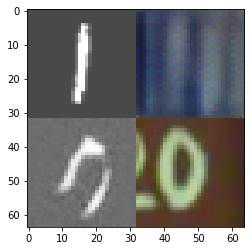

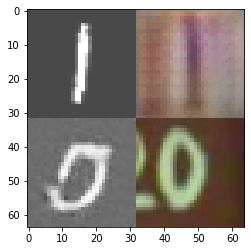

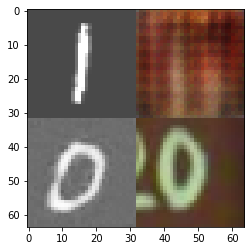

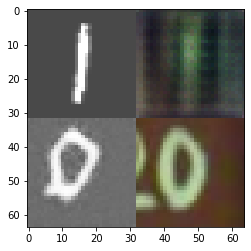

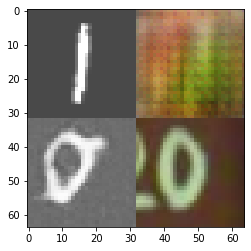

In [20]:
print('STEP 7: TRAIN THE MODEL')

label_realX = torch.full((bs, 1, 8, 8), real_label, dtype=torch.float32, device=device)
label_fakeX = torch.full((bs, 1, 8, 8), fake_label, dtype=torch.float32, device=device)

label_realY = torch.full((bs, 3, 8, 8), real_label, dtype=torch.float32, device=device)
label_fakeY = torch.full((bs, 3, 8, 8), fake_label, dtype=torch.float32, device=device)

result_img_list = []

def transpose(numpy):
    return np.transpose(numpy, [0,2,3,1])

def gray2rgb(numpy):
    return np.stack((numpy, numpy, numpy), 3)

for epoch in range(num_epochs):
    # weight initialization
    model_G_X.apply(weight_init)
    model_G_Y.apply(weight_init)
    model_D_X.apply(weight_init)
    model_D_Y.apply(weight_init)
    
    
    model_G_X.train()
    model_G_Y.train()
    model_D_X.train()
    model_D_Y.train()
    
    for i, data_X in enumerate(train_X_loader):
        
        
        data_X = data_X[0].to(device)
        data_Y = next(iter(train_Y_loader))[0].to(device)
        
        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()
        optimizer_G_X.zero_grad()
        optimizer_G_Y.zero_grad()
        # Update discriminator model
        #############
        
        fake_Y = model_G_X(data_X)
        fake_X = model_G_Y(data_Y)
        
        pred_fX = model_D_X(fake_X)
        pred_fY = model_D_Y(fake_Y)
        pred_rX = model_D_X(data_X)
        pred_rY = model_D_Y(data_Y)
        #############
        err_D = criterion_GAN(pred_rX, label_realX) + criterion_GAN(pred_rY, label_realY) + criterion_GAN(pred_fX, label_fakeX) + criterion_GAN(pred_fY, label_fakeY)
        
        err_D.backward()
        optimizer_D_X.step()
        optimizer_D_Y.step()
        
        # Update generator model
        
        #############
        fake_Y = model_G_X(data_X)
        fake_X = model_G_Y(data_Y)
        
        pred_fX = model_D_X(fake_X)
        pred_fY = model_D_Y(fake_Y)
        recon_Y = model_G_X(fake_X)
        recon_X = model_G_Y(fake_Y)
        
        
        #############
        
        err_G = criterion_GAN(pred_fX, label_realX) + criterion_GAN(pred_fY, label_realY)
        
        err_C = criterion_L1(recon_Y, data_Y) + criterion_L1(recon_X, data_X)
        
        err = err_G*1.5 + err_C*0.5
        
        err.backward()
        
        
        optimizer_G_X.step()
        optimizer_G_Y.step()
        # Output training stats
        if (i+1)%300 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_C: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_X_loader),
                     err_D.item(), err_G.item(), err_C.item()))

    
    
    model_G_X.eval()
    model_G_Y.eval()
    model_D_X.eval()
    model_D_Y.eval()

    for i, data_X in enumerate(test_X_loader):

        data_X = data_X[0].to(device)
        data_Y = next(iter(test_Y_loader))[0].to(device)

        output_Y = model_G_X(data_X).cpu().data.numpy()
        output_X = model_G_Y(data_Y).cpu().data.numpy()
        data_X = data_X.cpu().data.numpy()
        data_Y = data_Y.cpu().data.numpy()

        if i == 2:
            break

    X = np.concatenate((gray2rgb(transpose((data_X+1)/2)[:,:,:,0])[48], transpose((output_Y+1)/2)[48]), axis=1)
    Y = np.concatenate((gray2rgb(transpose((output_X+1)/2)[:,:,:,0])[48], transpose((data_Y+1)/2)[48]), axis=1)
    XY = np.concatenate((X, Y), axis=0)
    result_img_list.append(XY)
        
for j in range(len(result_img_list)):
    plt.imshow(result_img_list[j])
    if j+1 != len(result_img_list):
        plt.figure()

### *References*
[1] Zhu et al., "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", *ICCV*, 2017. <br>
[2] https://hardikbansal.github.io/CycleGANBlog/ <br>
[3] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010 <br>